In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import anndata


from importlib import reload
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import seaborn as sns




# 6A - SEACells summarize COVID-19 study

UMAPs of healthy and critical patients

In [87]:
sc_ad = sc.read('data/covid_singlecells.h5ad')
sc_ad = sc_ad[:, sc_ad.var_names[sc_ad.var['feature_types']=='Gene Expression']]
sc_ad.obs = sc_ad.obs.rename(columns={'initial_clustering':'celltype', 'sample_id':'sample'})

In [88]:
healthy_samples = sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary'] == 'Healthy']['sample'].unique()
healthy_samples


['MH8919179', 'MH8919227', 'MH8919226', 'MH8919178', 'newcastle65', ..., 'MH8919176', 'MH8919177', 'BGCV12_CV0926', 'BGCV08_CV0915', 'BGCV05_CV0929']
Length: 23
Categories (40, object): ['AP2', 'AP12', 'BGCV01_CV0902', 'BGCV01_CV0904', ..., 'newcastle21', 'newcastle21v2', 'newcastle65', 'newcastle74']

In [89]:
healthy = sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary'] == 'Healthy']
healthy.groupby('sample').count().loc[healthy_samples, ['total_counts']]

total_counts
sample                     
MH8919179              4316
MH8919227              2096
MH8919226              1190
MH8919178              7016
newcastle65            5655
MH8919282              6896
MH8919283              7100
BGCV10_CV0939          1719
BGCV09_CV0917          2924
BGCV01_CV0904          6853
BGCV13_CV0934          3408
MH8919333             12081
BGCV04_CV0911          1905
MH8919332              8004
BGCV14_CV0940          2958
newcastle74            6932
BGCV01_CV0902          1285
BGCV02_CV0902          2599
MH8919176              3217
MH8919177              2223
BGCV12_CV0926          2622
BGCV08_CV0915          1940
BGCV05_CV0929          1466

In [91]:
colors = {'B_cell': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
         'CD14': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
         'CD16': (1.0, 0.4980392156862745, 0.054901960784313725),
         'CD4': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
         'CD8': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
         'DCs': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
         'HSC': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
         'Lymph_prolif': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
         'MAIT': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
         'Mono_prolif': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
         'Plasmablast': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
         'Platelets': (1.0, 0.596078431372549, 0.5882352941176471),
         'RBC': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
         'Treg': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
         'gdT': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
         'pDC': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
         'Mixed': 'cornsilk',
         'NK': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)}

/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


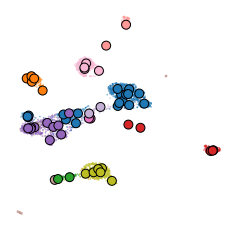

In [93]:
for sample in sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary'] == 'Healthy']['sample'].unique():
    # Compute UMAP for this sample
    tmp_ad = sc_ad[sc_ad.obs['sample']==sample].copy()
    
    tmp_ad.X = tmp_ad.layers['raw'].copy()

    sc.pp.normalize_total(tmp_ad)
    sc.pp.log1p(tmp_ad)
    sc.pp.highly_variable_genes(tmp_ad, batch_key='sample', n_top_genes=2500, inplace=True)

    tmp_ad = tmp_ad[:, tmp_ad.var_names[tmp_ad.var['highly_variable']]]
    sc.tl.pca(tmp_ad)
    sc.pp.neighbors(tmp_ad, use_rep='X_pca')
    sc.tl.umap(tmp_ad)

    plt.figure(figsize=(4,4))
    plt.scatter(tmp_ad.obsm['X_umap'][:,0], 
                tmp_ad.obsm['X_umap'][:,1], 
                color=[colors[i] for i in tmp_ad.obs['celltype']],
                s=0.5,
               alpha=0.5)

    df = pd.DataFrame(tmp_ad.obsm['X_umap']).set_index(tmp_ad.obs_names).join(tmp_ad.obs['SEACell']).groupby('SEACell').mean()
    df = df.join(tmp_ad.obs[['SEACell','celltype']].groupby('SEACell').agg(lambda x:x.value_counts().index[0])
                )
    plt.scatter(df[0], df[1], 
                s=80, 
                color=[colors[i] for i in df['celltype']], 
                linewidth=1,
                edgecolor='black', alpha=1)
    
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()
    plt.close()
    

/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


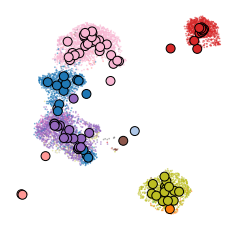

In [94]:
for sample in sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary'] == 'Critical']['sample'].unique():
    # Compute UMAP for this sample
    tmp_ad = sc_ad[sc_ad.obs['sample']==sample].copy()
    
    tmp_ad.X = tmp_ad.layers['raw'].copy()

    sc.pp.normalize_total(tmp_ad)
    sc.pp.log1p(tmp_ad)
    sc.pp.highly_variable_genes(tmp_ad, batch_key='sample', n_top_genes=2500, inplace=True)

    tmp_ad = tmp_ad[:, tmp_ad.var_names[tmp_ad.var['highly_variable']]]
    sc.tl.pca(tmp_ad)
    sc.pp.neighbors(tmp_ad, use_rep='X_pca')
    sc.tl.umap(tmp_ad)

    plt.figure(figsize=(4,4))
    plt.scatter(tmp_ad.obsm['X_umap'][:,0], 
                tmp_ad.obsm['X_umap'][:,1], 
                color=[colors[i] for i in tmp_ad.obs['celltype']],
                s=0.5,
               alpha=0.5)

    df = pd.DataFrame(tmp_ad.obsm['X_umap']).set_index(tmp_ad.obs_names).join(tmp_ad.obs['SEACell']).groupby('SEACell').mean()
    df = df.join(tmp_ad.obs[['SEACell','celltype']].groupby('SEACell').agg(lambda x:x.value_counts().index[0])
                )
    plt.scatter(df[0], df[1], 
                s=80, 
                color=[colors[i] for i in df['celltype']], 
                linewidth=1,
                edgecolor='black', alpha=1)
    
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()
    plt.close()
    

# 6B - SEACells enables efficient integration of large-scale single-cell datasets
SEACell UMAPs- Coloured by celltype, patient sample and disease status

In [168]:
mc_ad = sc.read('data/covid_metacells.h5ad')

In [169]:
mc_ad.obs.head()

sample  n_genes  n_genes_by_counts  \
index                                                                   
AAACCTGAGAAGGCCT-MH8919333      MH8919333     1209               1209   
AAACCTGAGACAGAGA-MH8919332      MH8919332      819                819   
AAACCTGAGACTTTCG-newcastle74  newcastle74      968                968   
AAACCTGAGAGACTTA-MH8919283      MH8919283      842                842   
AAACCTGAGCCCAGCT-MH8919178      MH8919178     2017               2017   

                              total_counts  total_counts_mt  pct_counts_mt  \
index                                                                        
AAACCTGAGAAGGCCT-MH8919333          2637.0             48.0       1.820250   
AAACCTGAGACAGAGA-MH8919332          1797.0             63.0       3.505843   
AAACCTGAGACTTTCG-newcastle74        2214.0             99.0       4.471545   
AAACCTGAGAGACTTA-MH8919283          2212.0            187.0       8.453888   
AAACCTGAGCCCAGCT-MH8919178          6319.0            233.0       3.687292   

                             full_clustering celltype Resample Collection_Day  \
index                                                                           
AAACCTGAGAAGGCCT-MH8919333         CD14_mono     CD14  Initial             D0   
AAACCTGAGACAGAGA-MH8919332            CD8.TE      CD8  Initial             D0   
AAACCTGAGACTTTCG-newcastle74          CD8.EM      CD8  Initial             D0   
AAACCTGAGAGACTTA-MH8919283        B_immature   B_cell  Initial             D0   
AAACCTGAGCCCAGCT-MH8919178         CD14_mono     CD14  Initial             D0   

                              ... Days_from_onset Site time_after_LPS  \
index                         ...                                       
AAACCTGAGAAGGCCT-MH8919333    ...         Healthy  Ncl            nan   
AAACCTGAGACAGAGA-MH8919332    ...         Healthy  Ncl            nan   
AAACCTGAGACTTTCG-newcastle74  ...         Healthy  Ncl            nan   
AAACCTGAGAGACTTA-MH8919283    ...         Healthy  Ncl            nan   
AAACCTGAGCCCAGCT-MH8919178    ...         Healthy  Ncl            nan   

                             Worst_Clinical_Status Outcome   patient_id  \
index                                                                     
AAACCTGAGAAGGCCT-MH8919333                 Healthy    Home    MH8919333   
AAACCTGAGACAGAGA-MH8919332                 Healthy    Home    MH8919332   
AAACCTGAGACTTTCG-newcastle74               Healthy    Home  newcastle74   
AAACCTGAGAGACTTA-MH8919283                 Healthy    Home    MH8919283   
AAACCTGAGCCCAGCT-MH8919178                 Healthy    Home    MH8919178   

                              n_counts Metacell_Size  \
index                                                  
AAACCTGAGAAGGCCT-MH8919333      4093.0             1   
AAACCTGAGACAGAGA-MH8919332      3796.0             1   
AAACCTGAGACTTTCG-newcastle74    6291.0             2   
AAACCTGAGAGACTTA-MH8919283     17562.0             3   
AAACCTGAGCCCAGCT-MH8919178    166548.0            11   

                                                     Metacell Metacell_Entropy  
index                                                                           
AAACCTGAGAAGGCCT-MH8919333    ACATCAGCAAGCGCTC-newcastle004v2         1.048740  
AAACCTGAGACAGAGA-MH8919332         AAACCTGAGACAGAGA-MH8919332         0.000000  
AAACCTGAGACTTTCG-newcastle74       AAACCTGAGACAGAGA-MH8919332         0.640808  
AAACCTGAGAGACTTA-MH8919283         AAACCTGAGATGCCAG-MH9143277         0.083965  
AAACCTGAGCCCAGCT-MH8919178         TGCCCTAGTCATACTG-MH8919282         1.381535  

[5 rows x 27 columns]

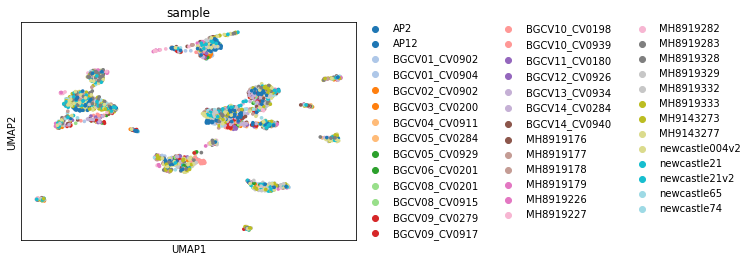

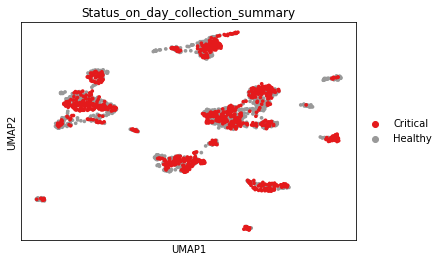

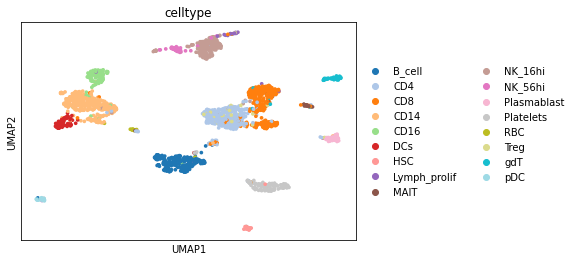

In [172]:
sc.pl.umap(mc_ad, color='sample', palette='tab20')
sc.pl.umap(mc_ad, color='Status_on_day_collection_summary', palette='Set1')
sc.pl.umap(mc_ad, color='celltype', palette='tab20')

# 6C - COVID-19 Sampled Enrichment in Aggregated Metacells

In [173]:
mmc_ad = sc.read('data/covid_metametacells_annotated.h5ad')
pvals = pd.read_csv('data/COVID_enrichment_pvals.csv', index_col=[0])

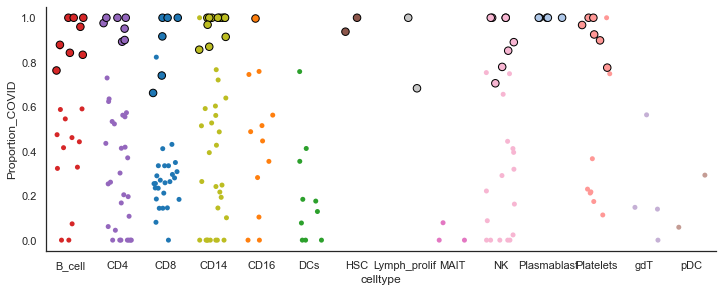

In [198]:
colors = {'B_cell': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
         'CD14': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
         'CD16': (1.0, 0.4980392156862745, 0.054901960784313725),
         'CD4': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
         'CD8': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
         'DCs': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
         'HSC': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
         'Lymph_prolif': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
         'MAIT': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
         'Mono_prolif': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
         'Plasmablast': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
         'Platelets': (1.0, 0.596078431372549, 0.5882352941176471),
         'RBC': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
         'Treg': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
         'gdT': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
         'pDC': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
         'Mixed': 'cornsilk',
         'NK': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)}

sns.color_palette(colors.values())

fig_size=1.5
fig = plt.figure(figsize=(8*fig_size,3*fig_size))
df = mmc_ad.obs
df['pvalue'] = pvals.loc[df.index]
df['sig_size'] = 5
df.loc[df['pvalue']<0.1, 'sig_size'] = 10

df['Proportion_COVID'] = 1 - df['Proportion_Healthy']
sns.stripplot(data=df[df['pvalue']>0.1], x='celltype', y='Proportion_COVID', 
                     hue='celltype', 
                     palette=colors, 
                     s = 5,
                     jitter=0.3)

sns.stripplot(data=df[df['pvalue']<=0.1], x='celltype', y='Proportion_COVID', 
                     hue='celltype', 
                     palette=colors, 
                     s = 7.5,
                     jitter=0.3,
             edgecolor='black', linewidth=1)

ax = plt.gca()
ax.legend_.remove()

sns.despine()

plt.savefig('COVID_stripplot_no_legend.png', dpi=200, transparent=True)

In [199]:
# Healthy to COVID Percentage change
healthy = sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary']=='Healthy']
healthy = healthy.groupby('celltype').count().iloc[:,0]
healthy.head()

celltype
B_cell     7479
CD4       28063
CD8       18705
CD14      10283
CD16       3460
Name: sample, dtype: int64

In [200]:
critical = sc_ad.obs[sc_ad.obs['Status_on_day_collection_summary']=='Critical']
critical = critical.groupby('celltype').count().iloc[:,0]
critical.head()

celltype
B_cell    11563
CD4       18342
CD8       10764
CD14      14222
CD16       2926
Name: sample, dtype: int64

In [201]:
healthy /= healthy.sum()
critical /= critical.sum()

In [202]:
percent_change = (critical-healthy)/healthy

In [203]:
percent_change = pd.DataFrame(percent_change).reset_index()
percent_change.head()

celltype    sample
0   B_cell  0.843811
1      CD4 -0.220525
2      CD8 -0.313714
3     CD14  0.649416
4     CD16  0.008527

In [204]:
percent_change = percent_change[~percent_change['celltype'].isin(['Mono_prolif','Treg','RBC'])]
percent_change['celltype'] = percent_change['celltype'].astype(str)

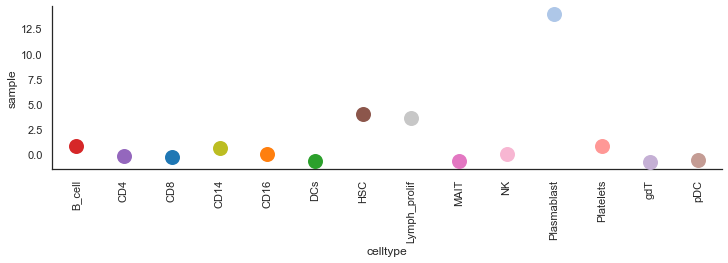

In [210]:
sns.set(style='white')

plt.figure(figsize=(12,3))
sns.swarmplot(y="sample", x="celltype", data=percent_change, palette=colors,s=15,marker='o')
# plt.ylim(-10,20)
plt.xticks(rotation=90)
sns.despine()
plt.show()
plt.close()



# 6D - Gene Expression in CD4 T-cell COVID-19 Metacells

## (i) Aggregated Metacells in CD4 T-Cells

In [175]:
colors = {}
for x in mc_ad.obs['celltype'].unique():
    if x != 'CD4':
        colors[x] = 'lightgrey'
    else:
        colors[x] = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)

/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


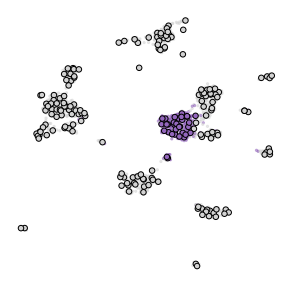

In [176]:
# Show the position of CD4 cells ONLY along with SEACell average position 
tmp_ad = mc_ad

plt.figure(figsize=(5,5))
ax = plt.gca()

ax.scatter(tmp_ad.obsm['X_umap'][:,0], 
           tmp_ad.obsm['X_umap'][:,1], 
           color=[colors[i] for i in tmp_ad.obs['celltype']],
           s=5,
           alpha=0.5)

df = pd.DataFrame(tmp_ad.obsm['X_umap']).set_index(tmp_ad.obs_names).join(tmp_ad.obs['Metacell']).groupby('Metacell').mean()
df = df.join(tmp_ad.obs[['Metacell','celltype']].groupby('Metacell').agg(lambda x:x.value_counts().index[0])
            )
df = df.loc[mmc_ad.obs_names]

df['color'] = 'black'
df['size'] = 30

ax.scatter(df[0], df[1], 
            s=df['size'], 
            color=[colors[i] for i in df['celltype']], 
            linewidth=1,
            edgecolor=df['color'].values, alpha=1)


ax.set_axis_off()

In [177]:
cd4_ad = mmc_ad[mmc_ad.obs_names[mmc_ad.obs['celltype']=='CD4']]

In [178]:
df = pd.DataFrame(tmp_ad.obsm['X_umap']).set_index(tmp_ad.obs_names).join(tmp_ad.obs['Metacell']).groupby('Metacell').mean()
df = df.join(tmp_ad.obs[['Metacell','celltype']].groupby('Metacell').agg(lambda x:x.value_counts().index[0]))

#Zoom into CD4s
cd4_umap = df[df['celltype']=='CD4'].drop('celltype', axis=1)
cd4_umap = cd4_umap[cd4_umap[0]>3]
cd4_umap = cd4_umap[cd4_umap[1]>-4]

In [179]:
genes_to_display = {'GGGCACTTCTTAGCCC-MH9143273':[['CCR10','FOXP3','IL2RA','TRBV4-1'],['red']],
                    'CGTCCATGTACTTCTT-MH8919329':[['IRF9', 'SOCS2','ISG15','IRF7','IFNAR2','NFKBIZ','CCR7','IFITM1'],['blue']],
                    'S12_GCGCAGTAGGACCACA-1':[['GZMK','RORC','CCR2','CCR6','HOPX','KLRG1','KLRB1','AB_CD2','TRAV1-2','IL7R'],['yellow']],
                   }

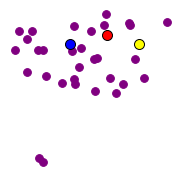

In [180]:
# cd4_umap['Average_Days_From_Onset'] = cd4_ad.obs.loc[cd4_umap.index, 'Average_Days_From_Onset']
fig = plt.figure(figsize=(3,3))
plt.scatter(cd4_umap[0], cd4_umap[1], s=60, color='purple')

for mc in genes_to_display.keys():
    plt.scatter(cd4_umap.loc[mc,0], cd4_umap.loc[mc,1], s=100, color=genes_to_display[mc][1], edgecolor='black',linewidth=1)

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

sns.despine(fig=fig, ax=ax, top=True, right=True, left=True, bottom=True, offset=None)

## (ii) Average Time Since Disease Onset

In [181]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='Greens', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:,:3]  # will return rgba, we take only first 3 so we get rgb
    color = [matplotlib.colors.rgb2hex(x) for x in rgb]
    return color

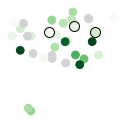

In [182]:
cd4_umap['Average_Days_From_Onset'] = cd4_ad.obs.loc[cd4_umap.index, 'Average_Days_From_Onset']
cd4_umap['color'] = color_map_color(cd4_umap['Average_Days_From_Onset'], 
                                   'Greens',
                                    cd4_umap['Average_Days_From_Onset'].min(),
                                    cd4_umap['Average_Days_From_Onset'].max()
                                   )

cd4_umap.loc[cd4_umap['Average_Days_From_Onset'].isna(), 'color'] = 'lightgrey'
# Color by time since disease onset
fig=plt.figure(figsize=(2,2))
plt.scatter(x=cd4_umap[0], y=cd4_umap[1], s=60, color=cd4_umap['color'])


for mc in genes_to_display.keys():
    plt.scatter(x=cd4_umap.loc[mc,0], y=cd4_umap.loc[mc,1], s=100, color=cd4_umap.loc[mc,'color'], edgecolor='black', linewidth=1)

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

sns.despine(fig=fig, ax=ax, top=True, right=True, left=True, bottom=True, offset=None)
plt.savefig('CD4_time_onset.png', dpi=200, transparent=True)

## (iii) Proportion Cells from COVID-19 Samples

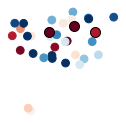

In [183]:
cd4_umap['Proportion_Healthy'] = cd4_ad.obs.loc[cd4_umap.index, 'Proportion_Healthy']

cd4_umap['color'] = color_map_color(cd4_umap['Proportion_Healthy'], 
                                   'RdBu',
                                    0,
                                    1
                                   )

# Color by time since disease onset
fig=plt.figure(figsize=(2,2))
plt.scatter(x=cd4_umap[0], y=cd4_umap[1], s=60, color=cd4_umap['color'])


for mc in genes_to_display.keys():
    plt.scatter(x=cd4_umap.loc[mc,0], y=cd4_umap.loc[mc,1], s=100, color=cd4_umap.loc[mc,'color'], edgecolor='black', linewidth=1)

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

sns.despine(fig=fig, ax=ax, top=True, right=True, left=True, bottom=True, offset=None)
plt.savefig('CD4_proportions.png', dpi=200, transparent=True)

## (iv) Gene Expression Programs in Aggregated Metacells

In [184]:
sc.pp.scale(cd4_ad)
genes = [x[0] for x in genes_to_display.values()]
genes = sum(list(genes), [])
expression = cd4_ad[:,genes].to_df()
expression = expression.T
expression.head()


/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Metacell  BGCV01_CGTTCTGCAAGCGTAG-1  ACCGTAAGTGTCGCTG-newcastle004v2  \
CCR10                     -1.393436                         1.713817   
FOXP3                     -1.691322                         1.615842   
IL2RA                     -2.211958                         1.070201   
TRBV4-1                   -2.938561                        -0.228095   
IRF9                      -1.931194                         0.920035   

Metacell  CATTATCTCGCCGTGA-MH8919333  GACCTGGCACCCAGTG-newcastle65  \
CCR10                       1.548506                      0.683593   
FOXP3                       1.143533                     -0.275836   
IL2RA                       0.920305                     -0.257462   
TRBV4-1                     1.424914                      1.103142   
IRF9                        1.070827                      0.950022   

Metacell  BGCV09_GGGATGACACCCAGTG-1  AACTCCCGTTATGCGT-newcastle21v2  \
CCR10                     -0.712356                       -0.694500   
FOXP3                     -0.541147                       -0.596923   
IL2RA                     -0.781521                        0.767870   
TRBV4-1                   -1.350986                       -0.457205   
IRF9                      -1.574294                        0.825175   

Metacell  ATTACTCTCGATAGAA-MH8919333  BGCV12_TCTCTAACAGACACTT-1  \
CCR10                       0.957908                  -1.297108   
FOXP3                       0.109346                  -0.065202   
IL2RA                       0.799367                   0.038892   
TRBV4-1                     0.854283                  -1.129681   
IRF9                        0.982986                  -1.129664   

Metacell  AACACGTAGGTGATAT-newcastle21  CGGGTCAGTACAAGTA-MH8919328  ...  \
CCR10                        -0.737923                    0.651361  ...   
FOXP3                        -1.251154                    0.631056  ...   
IL2RA                         0.934660                    0.229481  ...   
TRBV4-1                       0.693367                    0.029957  ...   
IRF9                          0.672472                    0.676816  ...   

Metacell  BGCV08_GACCTGGGTCATGCCG-1  TCACGAATCAGTCCCT-MH8919332  \
CCR10                     -0.040836                    1.587002   
FOXP3                      0.695313                    2.075171   
IL2RA                     -0.146203                    0.827851   
TRBV4-1                   -0.353402                    0.724978   
IRF9                      -0.951911                    0.588360   

Metacell  CTAGTGACACGTGAGA-newcastle65  GCACATAGTCTGATCA-MH8919282  \
CCR10                        -0.163484                    0.919563   
FOXP3                        -0.019161                    0.599796   
IL2RA                        -0.250618                    0.619685   
TRBV4-1                      -0.006868                    0.688183   
IRF9                          0.238607                    0.643776   

Metacell  TCTTTCCCAGACGCTC-newcastle65  TAGTGGTCAGGGATTG-MH8919282  \
CCR10                        -1.025414                   -0.652482   
FOXP3                        -0.762195                   -0.860458   
IL2RA                        -0.633250                   -1.443249   
TRBV4-1                      -0.309515                    0.541873   
IRF9                          0.053540                    0.813706   

Metacell  S13_CGTCTACGTCTGCCAG-1  GTGCATAAGTGGTCCC-MH8919282  \
CCR10                  -1.615366                   -0.457330   
FOXP3                  -1.304228                   -0.644173   
IL2RA                  -0.283516                   -0.482722   
TRBV4-1                 0.745659                    0.192487   
IRF9                   -0.678811                    0.531306   

Metacell  S12_CTCAGAACAGGTGGAT-1  S13_GCGCCAAGTTATCCGA-1  
CCR10                   0.893761                0.526816  
FOXP3                   0.138878                0.309571  
IL2RA                   1.148509               -0.330059  

In [185]:
expression['Associated_With'] = sum([genes_to_display[mc][1]*len(genes_to_display[mc][0]) for mc in genes_to_display], [])
expression['Associated_With'] = pd.Categorical(expression['Associated_With'], categories = ['blue', 'red', 'yellow'])
expression.sort_values(by='Associated_With').head()

Metacell  BGCV01_CGTTCTGCAAGCGTAG-1  ACCGTAAGTGTCGCTG-newcastle004v2  \
CCR7                      -2.332827                        -0.026847   
IFITM1                    -3.142118                         0.636169   
NFKBIZ                    -2.489648                         1.671505   
IFNAR2                    -1.883213                         1.010851   
IRF9                      -1.931194                         0.920035   

Metacell  CATTATCTCGCCGTGA-MH8919333  GACCTGGCACCCAGTG-newcastle65  \
CCR7                       -0.557242                     -0.438325   
IFITM1                     -0.002213                      0.618055   
NFKBIZ                     -0.104780                     -0.352732   
IFNAR2                      1.181157                      0.808443   
IRF9                        1.070827                      0.950022   

Metacell  BGCV09_GGGATGACACCCAGTG-1  AACTCCCGTTATGCGT-newcastle21v2  \
CCR7                      -0.636137                        1.403243   
IFITM1                    -1.015015                        0.483274   
NFKBIZ                    -0.819579                        1.639923   
IFNAR2                    -1.407769                        0.937468   
IRF9                      -1.574294                        0.825175   

Metacell  ATTACTCTCGATAGAA-MH8919333  BGCV12_TCTCTAACAGACACTT-1  \
CCR7                       -0.705251                   0.428995   
IFITM1                      0.208945                  -0.742786   
NFKBIZ                     -0.552701                  -0.983745   
IFNAR2                      0.899141                  -1.221230   
IRF9                        0.982986                  -1.129664   

Metacell  AACACGTAGGTGATAT-newcastle21  CGGGTCAGTACAAGTA-MH8919328  ...  \
CCR7                          1.728607                   -0.152010  ...   
IFITM1                        0.850394                    0.213448  ...   
NFKBIZ                        1.593737                   -0.191516  ...   
IFNAR2                        1.081683                    0.621669  ...   
IRF9                          0.672472                    0.676816  ...   

Metacell  TCACGAATCAGTCCCT-MH8919332  CTAGTGACACGTGAGA-newcastle65  \
CCR7                       -0.653807                      0.356532   
IFITM1                      0.978027                     -0.005840   
NFKBIZ                      0.161703                     -0.283123   
IFNAR2                      0.457932                      0.156898   
IRF9                        0.588360                      0.238607   

Metacell  GCACATAGTCTGATCA-MH8919282  TCTTTCCCAGACGCTC-newcastle65  \
CCR7                        0.561665                     -1.758861   
IFITM1                      0.565874                     -2.474458   
NFKBIZ                      0.173993                     -1.388225   
IFNAR2                      0.706328                     -0.190324   
IRF9                        0.643776                      0.053540   

Metacell  TAGTGGTCAGGGATTG-MH8919282  S13_CGTCTACGTCTGCCAG-1  \
CCR7                        1.308483                1.257754   
IFITM1                      0.137960                0.403957   
NFKBIZ                     -0.593674                0.404862   
IFNAR2                      0.983318               -0.814986   
IRF9                        0.813706               -0.678811   

Metacell  GTGCATAAGTGGTCCC-MH8919282  S12_CTCAGAACAGGTGGAT-1  \
CCR7                        0.030330                0.292388   
IFITM1                     -1.051653                0.866752   
NFKBIZ                      0.114707                0.271963   
IFNAR2                      0.605803               -1.277081   
IRF9                        0.531306               -0.478853   

Metacell  S13_GCGCCAAGTTATCCGA-1  Associated_With  
CCR7                    0.628969             blue  
IFITM1                  0.416069             blue  
NFKBIZ                 -0.058510             blue  
IFNAR2                 -0.482220             

In [186]:
expression = expression.set_index('Associated_With', append=True).sort_index(level='Associated_With')

In [187]:
col_colors = [colors[x] if x in colors else 'white' for x in expression.columns]

<Figure size 360x360 with 0 Axes>

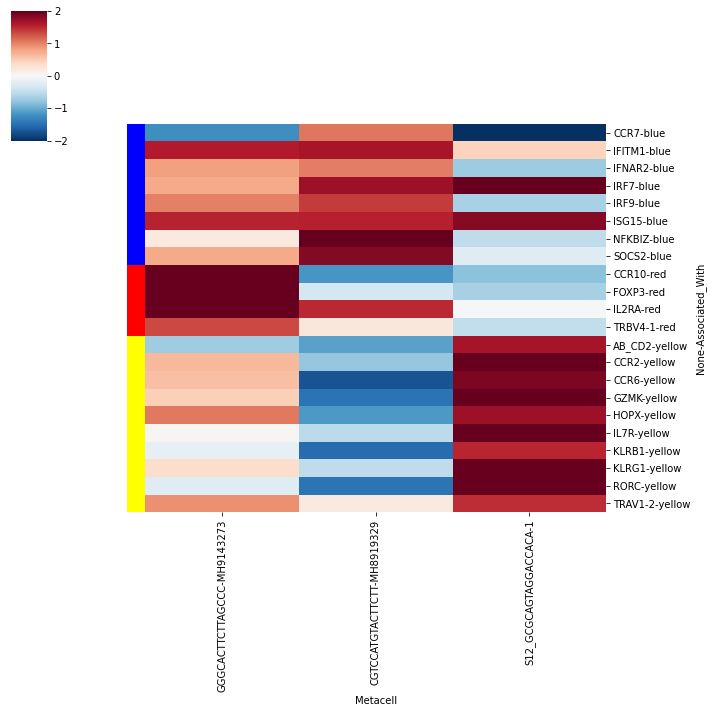

In [188]:
plt.figure(figsize=(5,5))
sns.clustermap(expression[genes_to_display.keys()], cmap='RdBu_r', vmin=-2, vmax=2, col_cluster=False, row_cluster=False, row_colors=expression.index.get_level_values('Associated_With'), col_colors=col_colors)
plt.show()
plt.close()